In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count #just to count
from PIL import Image

import torch #API
import torch.nn as nn #for neural networks
import torch.nn.functional as F #functional calls, like linear, etc
import torchvision.transforms as T #Transformers
from torch import transpose #operations
from torch import optim #optimizeers, like ADAM, RMSProp, SGD, ADelta, Momentum.

In [ ]:
import gy

### Next, we import IPython’s display module to aid us in plotting images to the screen later.

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [27]:
class DQN(nn.Module):
    def __init__(self,img_h,img_w):
        super().__init__()
        
        #self.fc1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (2,2))
        #self.fc1 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (2,2))
        self.fc1 = nn.Linear(in_features = (3 * img_h * img_w) , out_features = 64)
        self.fc2 = nn.Linear(in_features = 64, out_features = 64)
        self.out = nn.Linear(in_features = 64, out_features = 2) #left or right in the Cart-Pole dynamics
        
    def forward(self,t):

        t = t.flatten(start_dim = 1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))

        return self.out(t)        
        
        
        

In [28]:
from collections import namedtuple

Experience = namedtuple(
                'Experience',
                ('state','action','next_state','reward')
)

In [29]:
class ReplayMemory():
    def __init__(self,capacity):    
        self.memory = []
        self.capacity = capacity
        self.push_count = 0
    
    def push(self,experience):
        
        if(len(self.memory) < self.capacity):
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        
        self.push_count +=1
    
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    
    def can_provide_sample(self):
        return len(self.memory) >= batch_size
        

In [30]:
class Epsilon_Greedy():
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self,current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [31]:
class Agent():
    #the divice explicits the divice for PyTorch to use to tensor calculations ->  CPU or GPU
    def __init__(self,strategy,num_actions,device):
        
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        self.current_step = 0
        
        
    def select_action(self, state, policy_net):
        
    
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            return random.randrange(self.num_actions) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).item() # exploit    
        

In [32]:
class CarPoleEnvironment():
    def __init__(self,device):
        #unwrapped gives the back screen dynamics
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.device = device
        #Not yet rendered
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self,mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self,action):
        _, reward, done, info = self.env.step(action)
        self.done = done
        return torch.tensor([reward], device = self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            
            return black_screen
        
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            
            return s2 - s1

    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
        
    def crop_screen(self,screen):
        h = screen.shape[1]
        
        h1 = int (h * 0.4)
        h2 = int (h * 0.8)
        
        screen = screen[:, h1:h2, : ]
        
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

In [33]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [34]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

## Main Program

In [35]:
batch_size =  32
discount = 0.999

eps_start = 1
eps_end = 0.01
eps_decay = 0.001

target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [36]:
device = torch.device('cpu')

In [37]:
eps_greedy = Epsilon_Greedy(eps_start,eps_end,eps_decay)
cart_pole = CarPoleEnvironment(device)
replay_memory = ReplayMemory(memory_size)
agent = Agent(eps_greedy, cart_pole.env.action_space.n, device)

In [38]:
h = cart_pole.get_screen_height()
w = cart_pole.get_screen_width()

In [39]:
policy_net = DQN(h,w).to(device)
target_net = DQN(h,w).to(device)

In [40]:
#load pesos da policy net para a target
target_net.load_state_dict(policy_net.state_dict())
#meter target net fixa
target_net.eval()
#optimzer para back propagation = Adam
optimizer = optim.Adam(params=policy_net.parameters(),lr=lr)

# Now the final loop

### Some auxiliary functions too

In [41]:
class QValues():
    device = torch.device("cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):  
        
        #isto serve para filtrar todos os terminal states, pois não podemos passa-los à rede target policy.. não têm ações, buga na rede, fodeu tudo se passar, mais vale tar queto
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        #busca o device em cima, neste caso vou treinar em cpu
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [42]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)

    t2 = torch.cat([torch.Tensor(batch.action)]).type(torch.int64)
    #t2 = torch.from_numpy(np.array([batch.action]).astype(np.int64).reshape(256,1))
    
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

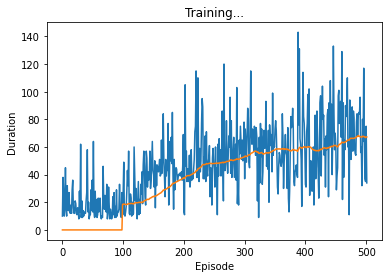

Episode 502 
 100 episode moving avg: 67.27


In [ ]:
episode_durations = []

for episode in range(num_episodes):
    cart_pole.reset()
    state = cart_pole.get_state()
    
    for timestep in count():
        
    
        action = agent.select_action(state,policy_net)  
        
        #Corresponding reward and state(image)
        reward = cart_pole.take_action(action)
        next_state = cart_pole.get_state()
    
        #push to the memory buffer
        replay_memory.push(Experience(state,action,reward,next_state))
        state = next_state
    
    
        #quando tiver um tamanho do replay memory maior que o meu batch size
        if(replay_memory.can_provide_sample()):
        
            experiences = replay_memory.sample(batch_size)
        
            states, actions, next_states, rewards = extract_tensors(experiences)
        
            current_q_values = QValues.get_current(policy_net,states,actions)
            next_q_values = QValues.get_next(target_net,next_states)
            
            #as written in Bell-man Equation
            target_values = rewards + (discount * next_q_values)
        
            loss = F.mse_loss(current_q_values,target_values.unsqueeze(1))
        
            #OS gradientes anteriores são eliminados, para não occorrer cumulative gradients
            optimizer.zero_grad()
        
            #back-propagation
            loss.backward()
        
        
            #optimization
            optimizer.step()
        
        if(cart_pole.done):
            episode_durations.append(timestep)
            plot(episode_durations,100)
            break
    
    if(episode % target_update == 0):
        target_net.load_state_dict(policy_net.state_dict())
        
cart_pole.close()